In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
from aging.plotting import format_plots, figure
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial.distance import pdist, squareform

In [3]:
format_plots()

In [8]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_


def minmax(df):
    return (df - df.min()) / (df.max() - df.min())

In [4]:
def read_male_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]
    df = df[use_syllables]
    return df, sizes_col


def read_female_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    # re-assign 52-wk old animals from their incorrect 8-wk old assignment
    x = ['d6f254af-d55a-427a-96e0-c452a233cbe2', '242bee8e-0ee7-45e7-8a13-678836a4cddb']

    idx = df.index.names
    tmp_df = df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    df = tmp_df.set_index(idx)

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    idx = size_df.index.names
    tmp_df = size_df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    size_df = tmp_df.set_index(idx)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]

    df = df[use_syllables]

    age_mapping = {
        93: 94,
        95: 94,
        97: 98,
        98: 98,
        102: 98,
        103: 105,
        105: 105,
        107: 105
    }

    df = df.reset_index(level='age')
    df['age'] = df['age'].map(age_mapping).fillna(df['age'])

    return df.set_index('age', append=True).reorder_levels(idx), sizes_col

In [5]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

In [9]:
df, sizes_col = read_male_ontogeny(keep_syllables)
female_df, female_sizes_col = read_female_ontogeny(keep_syllables)
df = pd.concat([df, female_df])

age = df.index.get_level_values("age")
syllable_counts_jax = df.astype(float)

label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
sex_id = label_encoder.fit_transform(
    np.hstack([np.zeros(len(df) - len(female_df)), np.ones(len(female_df))])[:, None]
).T

sort_idx = np.argsort(syllable_counts_jax.mean(0))[::-1]

df['sex'] = np.where(sex_id == 1)[0]
df = df.set_index('sex', append=True)

In [ ]:
for age, _df in df.groupby("age"):

    fig = figure(1.25, 1)
    ax = sns.heatmap(
        squareform(
            pdist(_df.sort_index(level=["sex", "uuid"]), metric="jensenshannon")
        ),
        vmax=0.55,
        vmin=0.09,
        cmap="cubehelix",
    )
    ax.set(title=str(age), xticks=[], yticks=[])

<Axes: xlabel='syllables'>

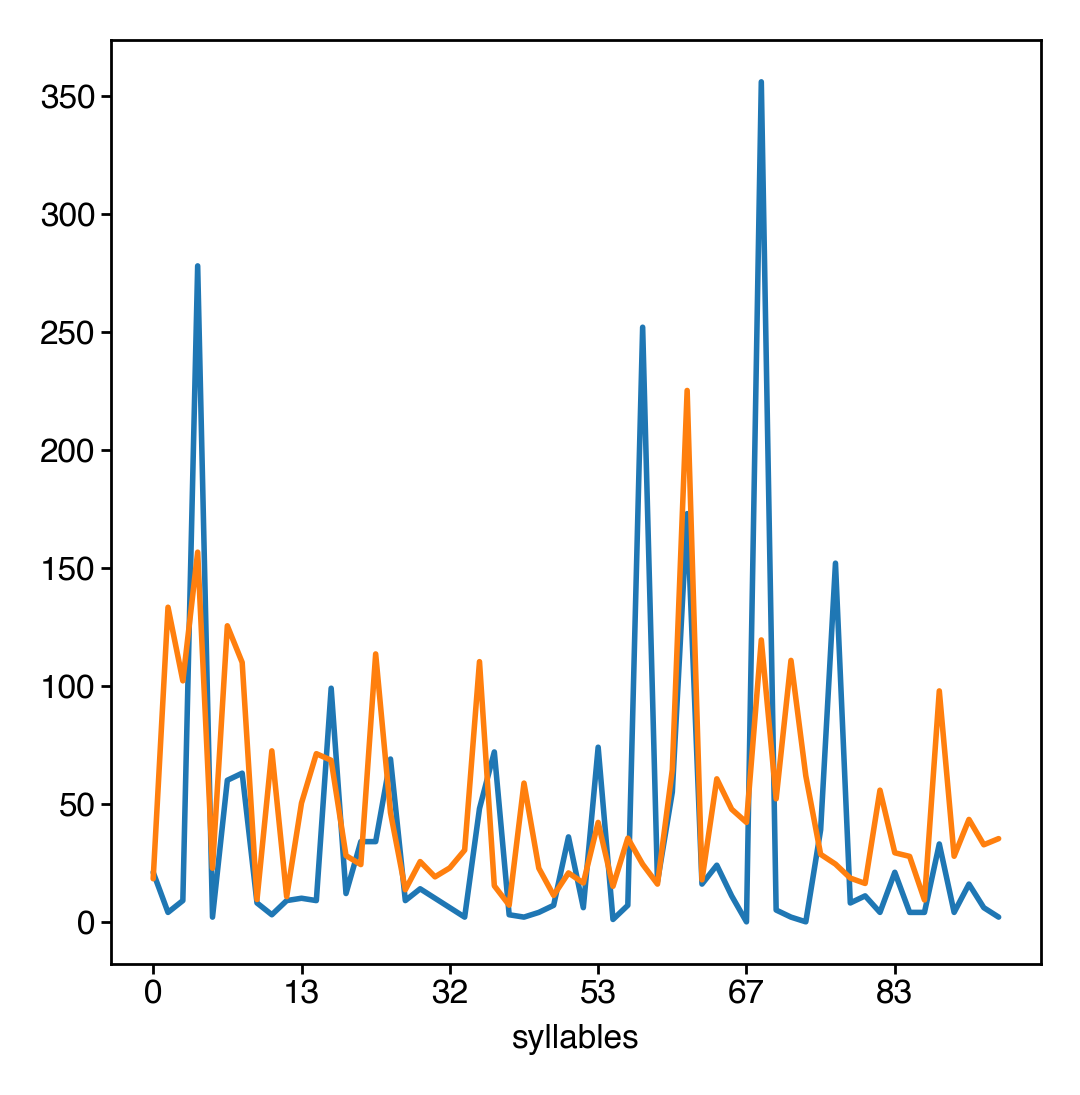

In [24]:
# df.query('age == 16').T.plot(legend=False)
df.query('age == 16').iloc[0].plot(legend=False)
df.query('age == 16').iloc[1:].mean().plot(legend=False)

<Axes: xlabel='syllables'>

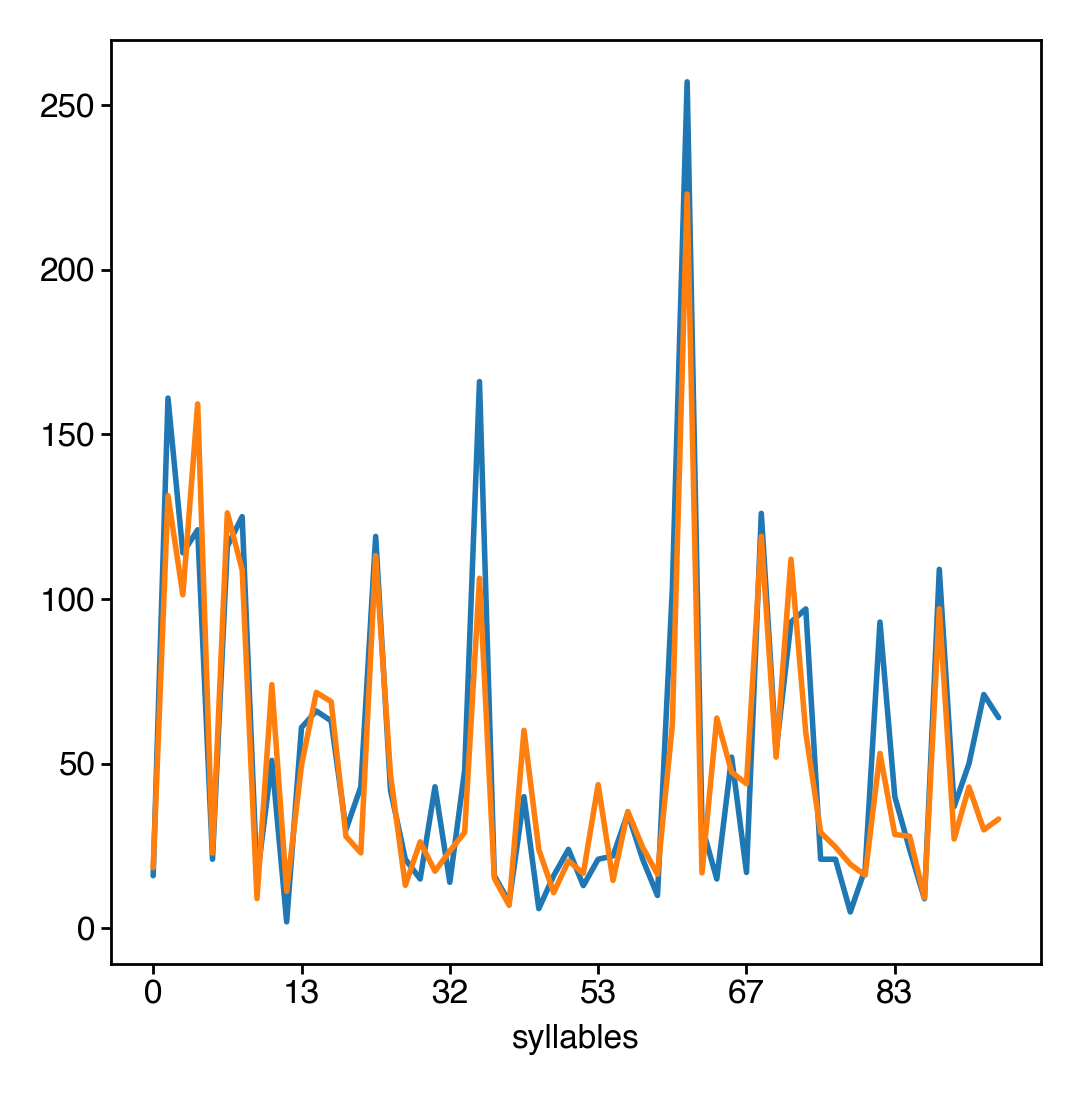

In [25]:
# df.query('age == 16').T.plot(legend=False)
df.query('age == 16').iloc[1].plot(legend=False)
df.query('age == 16').iloc[2:].mean().plot(legend=False)

In [26]:
df.query('age == 20 & sex == 0')

syllables                                                                                             0   \
age  mouse  subject_name session_name uuid                                 date                sex         
20.0 20M_01 20M_01       otgy_20M_01  3deb7df1-ff0b-4df3-ac0c-98a14065ed66 2023-09-30 10:24:15 0    19.0   
                                      66651f05-ad0b-43dc-b409-83403362ca5e 2023-09-30 07:28:52 0     8.0   
                                      b036b94a-d0ce-49f7-b7e9-eadf3f0f5773 2023-09-30 07:31:21 0    31.0   
                                      cf127cbd-b224-4e60-8d17-84b6d511d3a0 2023-09-30 07:26:30 0    15.0   
     20M_02 20M_02       otgy_20M_02  2616cd8d-c042-4adf-b368-b53bc3539c79 2023-09-30 09:51:06 0    18.0   
                                      58967f52-6a78-4f11-80ad-e9d161c0fe64 2023-09-30 09:51:27 0    20.0   
                                      6c200074-c770-4cb3-8cea-ed22ee3752ac 2023-09-30 12:50:42 0    12.0   
                                      bb6bbfec-9e1c-4abe-91bc-10710b7c39df 2023-09-30 09:51:48 0     5.0   
     20M_03 20M_03       otgy_20M_03  1098862b-c33d-4ecf-b240-fb5291baa4f1 2023-09-30 11:50:52 0    17.0   
                                      1cc7eda4-c142-4823-8942-9d72aa14dc15 2023-09-30 11:51:14 0    24.0   
                                      4b2f7120-1ff0-4464-b187-856ff826e36c 2023-09-30 11:51:34 0    25.0   
                                      72b64594-f770-4d31-b97b-bee443b0a0d1 2023-09-30 14:50:27 0    12.0   
     20M_04 20M_04       otgy_20M_04  19bfef0a-811d-4f33-a27b-b57a229be467 2023-09-30 13:44:56 0    16.0   
                                      5df7ab78-a5ef-42a7-b520-f5c138b25858 2023-09-30 16:44:09 0     7.0   
                                      d8a4d616-2b5b-40d6-9bbd-860554c9efe9 2023-09-30 13:45:20 0    25.0   
                                      f8f2a134-07f8-4570-8be0-d1bf34c54364 2023-09-30 13:44:31 0    27.0   

syllables                                                                                              2   \
age  mouse  subject_name session_name uuid                                 date                sex          
20.0 20M_01 20M_01       otgy_20M_01  3deb7df1-ff0b-4df3-ac0c-98a14065ed66 2023-09-30 10:24:15 0    200.0   
                                      66651f05-ad0b-43dc-b409-83403362ca5e 2023-09-30 07:28:52 0    176.0   
                                      b036b94a-d0ce-49f7-b7e9-eadf3f0f5773 2023-09-30 07:31:21 0    160.0   
                                      cf127cbd-b224-4e60-8d17-84b6d511d3a0 2023-09-30 07:26:30 0    143.0   
     20M_02 20M_02       otgy_20M_02  2616cd8d-c042-4adf-b368-b53bc3539c79 2023-09-30 09:51:06 0     64.0   
                                      58967f52-6a78-4f11-80ad-e9d161c0fe64 2023-09-30 09:51:27 0    158.0   
                                      6c200074-c770-4cb3-8cea-ed22ee3752ac 2023-09-30 12:50:42 0    179.0   
                                      bb6bbfec-9e1c-4abe-91bc-10710b7c39df 2023-09-30 09:51:48 0      2.0   
     20M_03 20M_03       otgy_20M_03  1098862b-c33d-4ecf-b240-fb5291baa4f1 2023-09-30 11:50:52 0     91.0   
                                      1cc7eda4-c142-4823-8942-9d72aa14dc15 2023-09-30 11:51:14 0     50.0   
                                      4b2f7120-1ff0-4464-b187-856ff826e36c 2023-09-30 11:51:34 0     46.0   
                                      72b64594-f770-4d31-b97b-bee443b0a0d1 2023-09-30 14:50:27 0    130.0   
     20M_04 20M_04       otgy_20M_04  19bfef0a-811d-4f33-a27b-b57a229be467 2023-09-30 13:44:56 0    155.0   
                                      5df7ab78-a5ef-42a7-b520-f5c138b25858 2023-09-30 16:44:09 0    205.0   
                                      d8a4d616-2b5b-40d6-9bbd-860554c9efe9 2023-09-30 13:45:20 0     47.0   
                                      f8f2a134-07f8-4570-8be0-d1bf34c54364 2023-09-30 13:44:31 0    131.0   

syllables                                                                                   

<Axes: xlabel='syllables'>

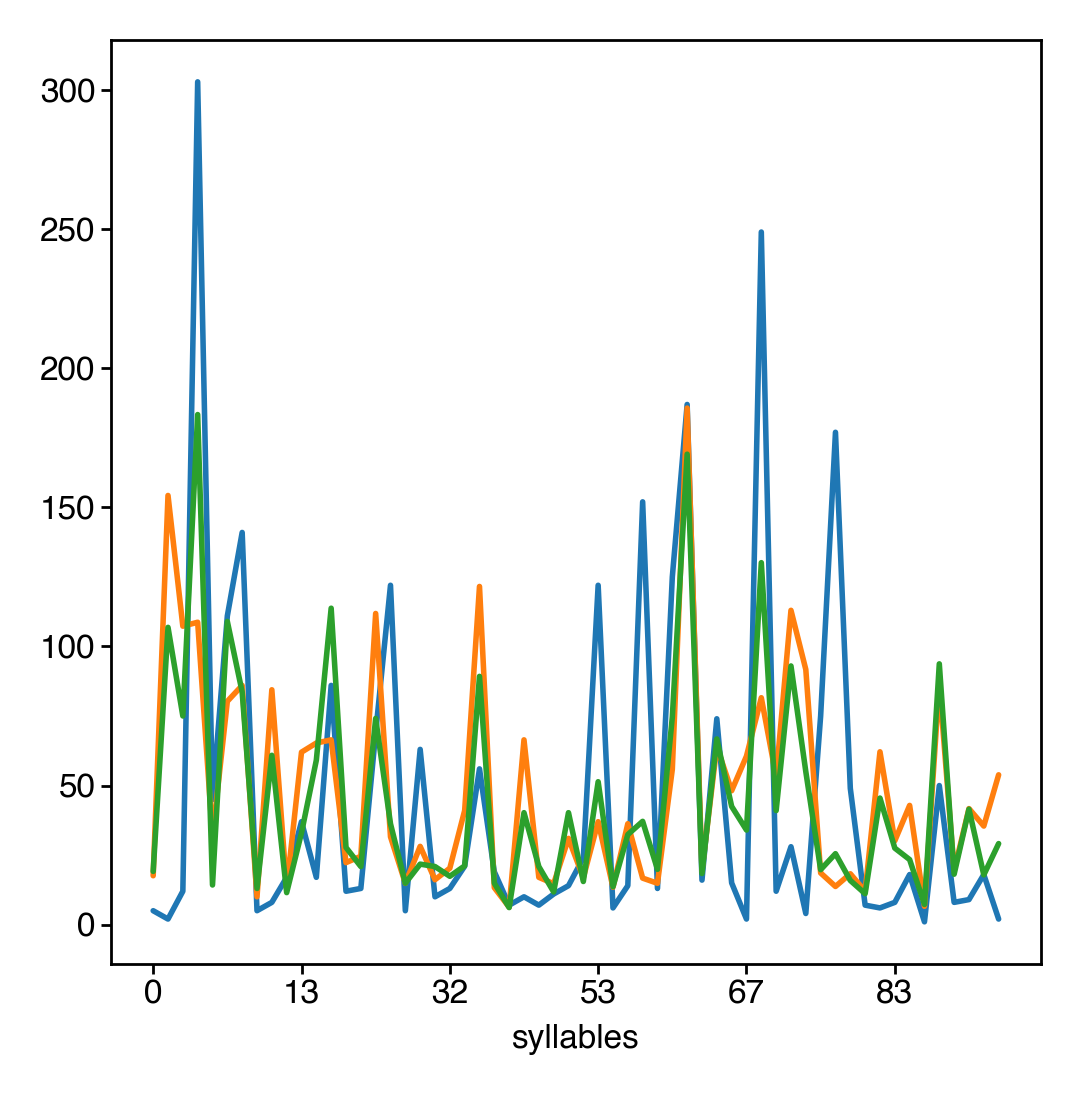

In [29]:
df.query('age == 20 & sex == 0').iloc[7].plot(legend=False)
df.query('age == 20 & sex == 0').iloc[:7].mean().plot(legend=False)
df.query('age == 20 & sex == 0').iloc[8:].mean().plot(legend=False)

In [31]:
# 5, 7
# 68314a59-cab0-4729-91dd-7fc1022acb2a
# 80ffd7f1-fa24-47b7-b17c-66de0bd9271c
df.query('age == 68 & sex == 0').sort_index(level='uuid')

syllables                                                                                             0   \
age  mouse  subject_name session_name uuid                                 date                sex         
68.0 68M_03 68M_03       otgy_68M_03  1d8ed919-00c2-4faf-9440-036bd30d9391 2023-10-06 12:24:02 0    13.0   
     68M_01 68M_01       otgy_68M_01  1f4bc26f-9772-4703-a2e0-4e3d0ee6ab44 2023-10-06 11:31:23 0    34.0   
     68M_03 68M_03       otgy_68M_03  2573d079-c945-4d3d-91d4-c69f4d4305bb 2023-10-06 12:23:23 0    19.0   
     68M_01 68M_01       otgy_68M_01  3fe6fd3b-01bd-443f-b505-7baed61e8e46 2023-10-06 08:31:45 0    26.0   
     68M_04 68M_04       otgy_68M_04  68314a59-cab0-4729-91dd-7fc1022acb2a 2023-10-06 17:16:18 0    18.0   
                                      6f52b721-cfaf-4ecf-93f4-1b0268fe2b89 2023-10-06 14:16:58 0    19.0   
                                      80ffd7f1-fa24-47b7-b17c-66de0bd9271c 2023-10-06 14:17:14 0    13.0   
     68M_01 68M_01       otgy_68M_01  af3c12ba-3934-488e-94d0-7c097967ca66 2023-10-06 08:32:21 0    10.0   
     68M_02 68M_02       otgy_68M_02  b2309bcc-8869-49ec-a49e-ee301ee54f46 2023-10-06 10:31:43 0    18.0   
     68M_01 68M_01       otgy_68M_01  b9df0186-92b0-455b-95d8-c2e9a29bbae8 2023-10-06 08:32:04 0     6.0   
     68M_02 68M_02       otgy_68M_02  d19eea19-5b35-4a7b-8682-acb3cbcc63b9 2023-10-06 10:32:20 0    16.0   
     68M_04 68M_04       otgy_68M_04  e103c185-19ac-4b91-9fd9-3f880a23f31d 2023-10-06 14:16:37 0     7.0   
     68M_03 68M_03       otgy_68M_03  efa1ef59-7275-405b-9b2a-657979b439f3 2023-10-06 15:23:04 0     9.0   
     68M_02 68M_02       otgy_68M_02  eff9ef29-fc4b-4edd-9dee-0734c9945e94 2023-10-06 13:33:01 0    11.0   
                                      f8981c98-d727-4832-8e5f-bdf45bb828a7 2023-10-06 10:32:05 0     7.0   

syllables                                                                                              2   \
age  mouse  subject_name session_name uuid                                 date                sex          
68.0 68M_03 68M_03       otgy_68M_03  1d8ed919-00c2-4faf-9440-036bd30d9391 2023-10-06 12:24:02 0    137.0   
     68M_01 68M_01       otgy_68M_01  1f4bc26f-9772-4703-a2e0-4e3d0ee6ab44 2023-10-06 11:31:23 0     79.0   
     68M_03 68M_03       otgy_68M_03  2573d079-c945-4d3d-91d4-c69f4d4305bb 2023-10-06 12:23:23 0     90.0   
     68M_01 68M_01       otgy_68M_01  3fe6fd3b-01bd-443f-b505-7baed61e8e46 2023-10-06 08:31:45 0     80.0   
     68M_04 68M_04       otgy_68M_04  68314a59-cab0-4729-91dd-7fc1022acb2a 2023-10-06 17:16:18 0    183.0   
                                      6f52b721-cfaf-4ecf-93f4-1b0268fe2b89 2023-10-06 14:16:58 0     22.0   
                                      80ffd7f1-fa24-47b7-b17c-66de0bd9271c 2023-10-06 14:17:14 0    123.0   
     68M_01 68M_01       otgy_68M_01  af3c12ba-3934-488e-94d0-7c097967ca66 2023-10-06 08:32:21 0    105.0   
     68M_02 68M_02       otgy_68M_02  b2309bcc-8869-49ec-a49e-ee301ee54f46 2023-10-06 10:31:43 0    102.0   
     68M_01 68M_01       otgy_68M_01  b9df0186-92b0-455b-95d8-c2e9a29bbae8 2023-10-06 08:32:04 0     55.0   
     68M_02 68M_02       otgy_68M_02  d19eea19-5b35-4a7b-8682-acb3cbcc63b9 2023-10-06 10:32:20 0     64.0   
     68M_04 68M_04       otgy_68M_04  e103c185-19ac-4b91-9fd9-3f880a23f31d 2023-10-06 14:16:37 0     46.0   
     68M_03 68M_03       otgy_68M_03  efa1ef59-7275-405b-9b2a-657979b439f3 2023-10-06 15:23:04 0     90.0   
     68M_02 68M_02       otgy_68M_02  eff9ef29-fc4b-4edd-9dee-0734c9945e94 2023-10-06 13:33:01 0     92.0   
                                      f8981c98-d727-4832-8e5f-bdf45bb828a7 2023-10-06 10:32:05 0     58.0   

syllables                                                                                              4   \
age  mouse  subject_name session_name uuid                                 date                sex          
68.0 68M_03 68M_03       otgy_68M_03  1d8ed919-00c2-4faf-9440-036bd30d9391 2023-10-06 12:24

<Axes: xlabel='syllables'>

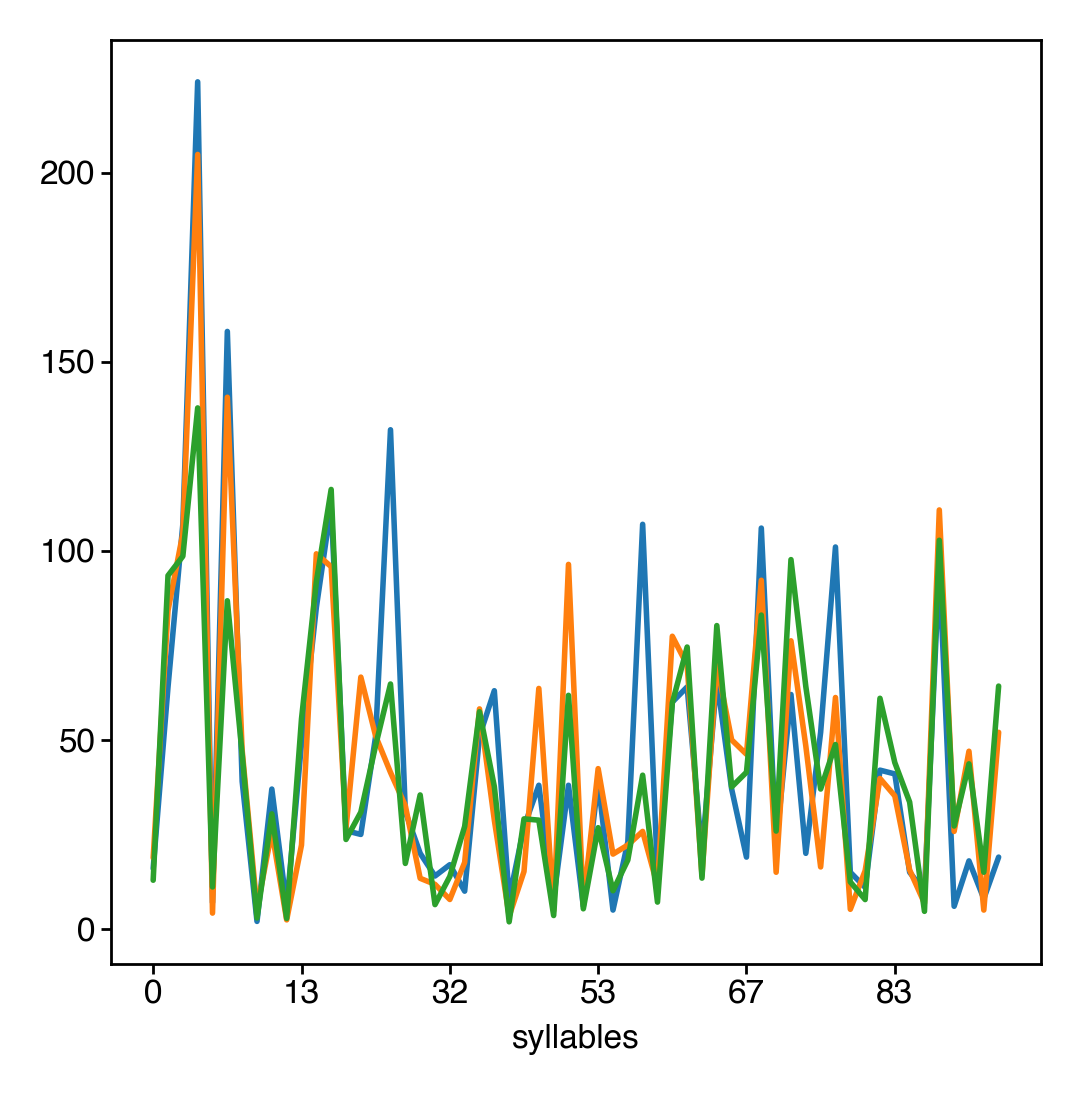

In [32]:
tmp = df.query('age == 68 & sex == 0')
tmp.iloc[5].plot(legend=False)
tmp.iloc[:5].mean().plot(legend=False)
tmp.iloc[6:].mean().plot(legend=False)